# Classification par Réseau de Neurones - 20 Newsgroups

## Objectifs

Ce notebook implémente un modèle de classification par réseau de neurones pour le jeu de données **20 Newsgroups**.

**Objectifs principaux :**
- Préparer et prétraiter les données textuelles
- Implémenter un modèle de réseau de neurones (MLP)
- Comparer avec une baseline simple
- Évaluer les performances avec des métriques pertinentes
- Documenter les choix d'hyperparamètres et discuter des limites


## 1. Import des bibliothèques et configuration de la reproductibilité


In [ ]:
    # Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Pas besoin de configuration HTTP car on charge directement depuis les dossiers locaux

# Data manipulation
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.datasets import fetch_20newsgroups
from urllib.error import HTTPError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Versions des bibliothèques (à documenter)
print("Versions des bibliothèques principales :")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {__import__('sklearn').__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300  # Haute qualité pour sauvegarde

# Créer le dossier figures pour les graphiques
import os
figures_dir = 'figures'
os.makedirs(figures_dir, exist_ok=True)
print(f"Dossier 'figures' cree/prepare pour les graphiques")


Versions des bibliothèques principales :
NumPy: 2.4.0
Pandas: 2.3.3
Scikit-learn: 1.8.0
Matplotlib: 3.10.8
Seaborn: 0.13.2
Dossier 'figures' cree/prepare pour les graphiques


## 2. Chargement des données


In [5]:
# Chargement du jeu de données 20 Newsgroups
# On utilise un sous-ensemble pour accélérer l'entraînement
# remove=('headers', 'footers', 'quotes') supprime les métadonnées

# Imports nécessaires (au cas où la cellule d'imports n'a pas été exécutée)
import os
from sklearn.datasets import fetch_20newsgroups, get_data_home
from urllib.error import HTTPError

# Vérifier si RANDOM_STATE est défini, sinon le définir
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

print("Chargement du jeu de données 20 Newsgroups...")

# Essayer d'abord de charger depuis les dossiers locaux si disponibles
data_loaded = False
possible_paths = [
    os.path.join(os.path.expanduser("~"), "Downloads", "20news-bydate"),
    os.path.join(os.getcwd(), "20news-bydate"),
    os.path.join(get_data_home(), "20news-bydate"),
]

train_dir = None
test_dir = None

for base_path in possible_paths:
    train_path = os.path.join(base_path, "20news-bydate-train")
    test_path = os.path.join(base_path, "20news-bydate-test")
    if os.path.exists(train_path) and os.path.exists(test_path):
        train_dir = train_path
        test_dir = test_path
        print(f"✓ Dossiers locaux trouvés : {base_path}")
        break

if train_dir and test_dir:
    # Charger depuis les dossiers locaux
    print("Chargement depuis les dossiers locaux...")
    try:
        # fetch_20newsgroups attend que data_home pointe vers le dossier parent
        # qui contient le dossier 20news-bydate
        # Si train_dir est C:\Users\rimla\Downloads\20news-bydate\20news-bydate-train
        # alors data_home doit être C:\Users\rimla\Downloads
        data_home_local = os.path.dirname(os.path.dirname(train_dir))
        print(f"Utilisation de data_home: {data_home_local}")
        
        newsgroups_train = fetch_20newsgroups(
            subset='train',
            data_home=data_home_local,
            remove=('headers', 'footers', 'quotes'),
            shuffle=True,
            random_state=RANDOM_STATE,
            download_if_missing=False
        )
        
        newsgroups_test = fetch_20newsgroups(
            subset='test',
            data_home=data_home_local,
            remove=('headers', 'footers', 'quotes'),
            shuffle=True,
            random_state=RANDOM_STATE,
            download_if_missing=False
        )
        data_loaded = True
        print(" Données chargées depuis les dossiers locaux!")
    except Exception as e:
        print(f" Erreur lors du chargement depuis les dossiers locaux : {e}")
        print("Tentative avec fetch_20newsgroups standard...")

# Si le chargement local a échoué, utiliser fetch_20newsgroups standard
if not data_loaded:
    try:
        print("Tentative de chargement avec fetch_20newsgroups...")
        newsgroups_train = fetch_20newsgroups(
            subset='train',
            remove=('headers', 'footers', 'quotes'),
            shuffle=True,
            random_state=RANDOM_STATE,
            download_if_missing=True  # Permettre le téléchargement automatique
        )
        
        newsgroups_test = fetch_20newsgroups(
            subset='test',
            remove=('headers', 'footers', 'quotes'),
            shuffle=True,
            random_state=RANDOM_STATE,
            download_if_missing=True  # Permettre le téléchargement automatique
        )
        print(" Données chargées avec fetch_20newsgroups!")
        data_loaded = True
        
    except (HTTPError, OSError) as e:
        if isinstance(e, HTTPError):
            print(f"\n Erreur HTTP {e.code}: {e.reason}")
        else:
            print(f"\n Erreur : {e}")
        print("\n🔧 Solutions alternatives :")
        print("1. Vérifiez votre connexion Internet")
        print("2. Téléchargez manuellement depuis : http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz")
        print("3. Extrayez dans un dossier et modifiez le code pour pointer vers ce dossier")
        raise
    except Exception as e:
        print(f"\n Erreur lors du chargement : {e}")
        print("\nInstructions pour téléchargement manuel :")
        print("1. Téléchargez depuis : http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz")
        print("2. Extrayez dans un dossier accessible")
        print("3. Modifiez le code pour pointer vers ce dossier")
        raise

if not data_loaded:
    raise RuntimeError("Impossible de charger les données. Vérifiez votre configuration.")

# Extraction des données
X_train_raw = newsgroups_train.data
y_train = newsgroups_train.target
X_test_raw = newsgroups_test.data
y_test = newsgroups_test.target

# Noms des classes
class_names = newsgroups_train.target_names

print(f"\n Données chargées avec succès!")
print(f"Nombre d'échantillons d'entraînement : {len(X_train_raw)}")
print(f"Nombre d'échantillons de test : {len(X_test_raw)}")
print(f"Nombre de classes : {len(class_names)}")
print(f"\nClasses : {class_names}")


Chargement du jeu de données 20 Newsgroups...
✓ Dossiers locaux trouvés : C:\Users\rimla\Downloads\20news-bydate
Chargement depuis les dossiers locaux...
Utilisation de data_home: C:\Users\rimla\Downloads
 Erreur lors du chargement depuis les dossiers locaux : 20Newsgroups dataset not found
Tentative avec fetch_20newsgroups standard...
Tentative de chargement avec fetch_20newsgroups...
 Données chargées avec fetch_20newsgroups!

 Données chargées avec succès!
Nombre d'échantillons d'entraînement : 11314
Nombre d'échantillons de test : 7532
Nombre de classes : 20

Classes : ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


## 3. Exploration rapide des données (EDA)


=== Distribution des classes (train) ===
                      Classe  Nombre  Pourcentage
0                alt.atheism     480         4.24
1              comp.graphics     584         5.16
2    comp.os.ms-windows.misc     591         5.22
3   comp.sys.ibm.pc.hardware     590         5.21
4      comp.sys.mac.hardware     578         5.11
5             comp.windows.x     593         5.24
6               misc.forsale     585         5.17
7                  rec.autos     594         5.25
8            rec.motorcycles     598         5.29
9         rec.sport.baseball     597         5.28
10          rec.sport.hockey     600         5.30
11                 sci.crypt     595         5.26
12           sci.electronics     591         5.22
13                   sci.med     594         5.25
14                 sci.space     593         5.24
15    soc.religion.christian     599         5.29
16        talk.politics.guns     546         4.83
17     talk.politics.mideast     564         4.98
18       

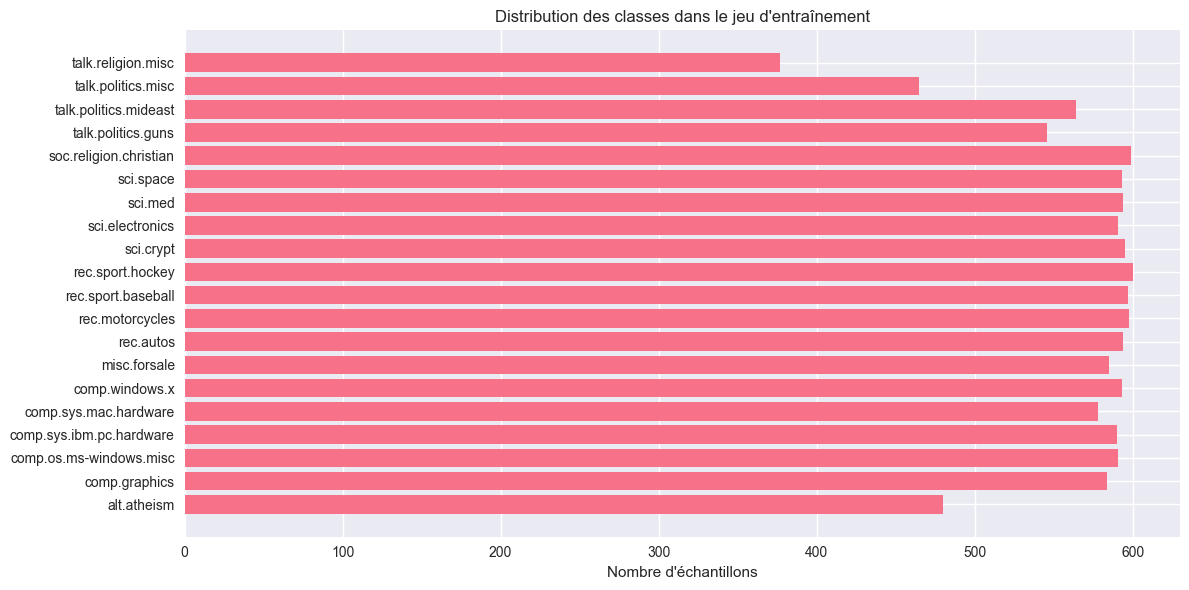

In [ ]:
# Analyse de la distribution des classes
print("=== Distribution des classes (train) ===")
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = pd.DataFrame({
    'Classe': [class_names[i] for i in unique],
    'Nombre': counts,
    'Pourcentage': (counts / len(y_train) * 100).round(2)
})
print(class_distribution)

# Visualisation de la distribution
plt.figure(figsize=(12, 6))
plt.barh(range(len(class_names)), counts)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel("Nombre d'échantillons")
plt.title("Distribution des classes dans le jeu d'entraînement")
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


=== Exemple de document ===
Classe : sci.electronics

Texte (200 premiers caractères) :
From: wtm@uhura.neoucom.edu (Bill Mayhew)
Subject: Re: How to the disks copy protected.
Organization: Northeastern Ohio Universities College of Medicine
Lines: 23

Write a good manual to go with the s...

=== Statistiques sur la longueur des documents ===
Train - Moyenne : 287.5 mots, Médiane : 176.0 mots
Test - Moyenne : 277.9 mots, Médiane : 173.0 mots


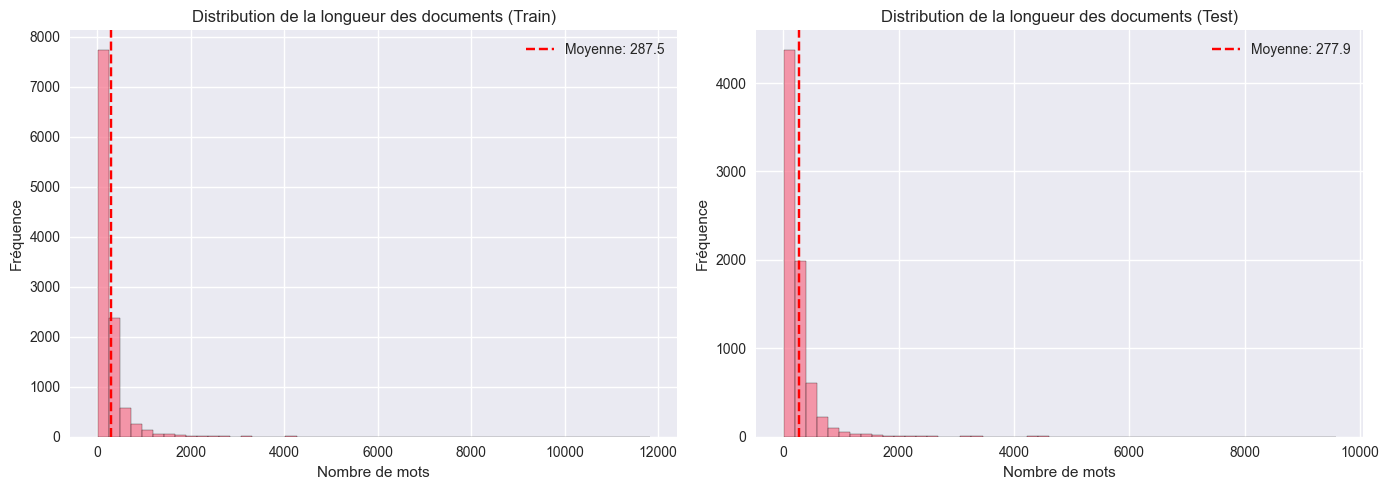

In [ ]:
# Analyse de quelques exemples
print("=== Exemple de document ===")
print(f"Classe : {class_names[y_train[0]]}")
print(f"\nTexte (200 premiers caractères) :\n{X_train_raw[0][:200]}...")

# Statistiques sur la longueur des documents
train_lengths = [len(doc.split()) for doc in X_train_raw]
test_lengths = [len(doc.split()) for doc in X_test_raw]

print("\n=== Statistiques sur la longueur des documents ===")
print(f"Train - Moyenne : {np.mean(train_lengths):.1f} mots, Médiane : {np.median(train_lengths):.1f} mots")
print(f"Test - Moyenne : {np.mean(test_lengths):.1f} mots, Médiane : {np.median(test_lengths):.1f} mots")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de mots')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de la longueur des documents (Train)')
axes[0].axvline(np.mean(train_lengths), color='r', linestyle='--', label=f'Moyenne: {np.mean(train_lengths):.1f}')
axes[0].legend()

axes[1].hist(test_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution de la longueur des documents (Test)')
axes[1].axvline(np.mean(test_lengths), color='r', linestyle='--', label=f'Moyenne: {np.mean(test_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('document_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Prétraitement des données


In [ ]:
# Vectorisation TF-IDF
# On limite le nombre de features pour accélérer l'entraînement
print("Vectorisation TF-IDF en cours...")

vectorizer = TfidfVectorizer(
    max_features=5000,  # Limite le vocabulaire à 5000 mots les plus fréquents
    min_df=2,           # Ignore les mots apparaissant dans moins de 2 documents
    max_df=0.95,        # Ignore les mots apparaissant dans plus de 95% des documents
    stop_words='english',  # Supprime les mots vides anglais
    lowercase=True,
    strip_accents='unicode',
    ngram_range=(1, 2)  # Unigrammes et bigrammes
)

# Transformation des données
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

print(f"Forme de la matrice d'entraînement : {X_train.shape}")
print(f"Forme de la matrice de test : {X_test.shape}")
print(f"Nombre de features (vocabulaire) : {X_train.shape[1]}")

# Conversion en format dense pour le MLP (peut être mémoire-intensive)
# On pourrait utiliser un sous-échantillon si nécessaire
print("\nConversion en format dense...")
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

print(f"Forme finale (dense) : Train {X_train_dense.shape}, Test {X_test_dense.shape}")


Vectorisation TF-IDF en cours...
Forme de la matrice d'entraînement : (11314, 5000)
Forme de la matrice de test : (7532, 5000)
Nombre de features (vocabulaire) : 5000

Conversion en format dense...
Forme finale (dense) : Train (11314, 5000), Test (7532, 5000)


In [ ]:
# Normalisation/Standardisation
# Les données TF-IDF sont déjà normalisées, mais on peut appliquer une standardisation supplémentaire
# pour améliorer la convergence du réseau de neurones

scaler = StandardScaler(with_mean=False)  # with_mean=False car matrices creuses
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

print("Standardisation terminée.")
print(f"Moyenne des features (train) : {X_train_scaled.mean(axis=0).mean():.6f}")
print(f"Écart-type des features (train) : {X_train_scaled.std(axis=0).mean():.6f}")


Standardisation terminée.
Moyenne des features (train) : 0.092503
Écart-type des features (train) : 1.000000


## 5. Répartition des données (Train/Validation/Test)


In [ ]:
# Le dataset 20 Newsgroups est déjà divisé en train/test
# On crée une validation set à partir du train pour le tuning

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train  # Maintient la distribution des classes
)

print(f"Train : {X_train_final.shape[0]} échantillons")
print(f"Validation : {X_val.shape[0]} échantillons")
print(f"Test : {X_test_scaled.shape[0]} échantillons")

# Vérification de la distribution des classes
print("\nDistribution des classes dans chaque split :")
for name, y in [('Train', y_train_final), ('Validation', y_val), ('Test', y_test)]:
    unique, counts = np.unique(y, return_counts=True)
    print(f"{name}: {dict(zip([class_names[i] for i in unique], counts))}")


Train : 9051 échantillons
Validation : 2263 échantillons
Test : 7532 échantillons

Distribution des classes dans chaque split :
Train: {'alt.atheism': np.int64(384), 'comp.graphics': np.int64(467), 'comp.os.ms-windows.misc': np.int64(473), 'comp.sys.ibm.pc.hardware': np.int64(472), 'comp.sys.mac.hardware': np.int64(463), 'comp.windows.x': np.int64(474), 'misc.forsale': np.int64(468), 'rec.autos': np.int64(475), 'rec.motorcycles': np.int64(478), 'rec.sport.baseball': np.int64(478), 'rec.sport.hockey': np.int64(480), 'sci.crypt': np.int64(476), 'sci.electronics': np.int64(473), 'sci.med': np.int64(475), 'sci.space': np.int64(474), 'soc.religion.christian': np.int64(479), 'talk.politics.guns': np.int64(437), 'talk.politics.mideast': np.int64(451), 'talk.politics.misc': np.int64(372), 'talk.religion.misc': np.int64(302)}
Validation: {'alt.atheism': np.int64(96), 'comp.graphics': np.int64(117), 'comp.os.ms-windows.misc': np.int64(118), 'comp.sys.ibm.pc.hardware': np.int64(118), 'comp.sys.ma

## 6. Modèle Baseline


In [ ]:
# Baseline : Classifieur naïf (stratégie la plus fréquente)
print("=== Entraînement du modèle baseline ===")

baseline = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
baseline.fit(X_train_final, y_train_final)

# Prédictions
y_train_baseline = baseline.predict(X_train_final)
y_val_baseline = baseline.predict(X_val)
y_test_baseline = baseline.predict(X_test_scaled)

# Métriques
train_acc_baseline = accuracy_score(y_train_final, y_train_baseline)
val_acc_baseline = accuracy_score(y_val, y_val_baseline)
test_acc_baseline = accuracy_score(y_test, y_test_baseline)

train_f1_baseline = f1_score(y_train_final, y_train_baseline, average='weighted')
val_f1_baseline = f1_score(y_val, y_val_baseline, average='weighted')
test_f1_baseline = f1_score(y_test, y_test_baseline, average='weighted')

print(f"\n=== Résultats Baseline ===")
print(f"Train - Accuracy: {train_acc_baseline:.4f}, F1-score: {train_f1_baseline:.4f}")
print(f"Validation - Accuracy: {val_acc_baseline:.4f}, F1-score: {val_f1_baseline:.4f}")
print(f"Test - Accuracy: {test_acc_baseline:.4f}, F1-score: {test_f1_baseline:.4f}")


=== Entraînement du modèle baseline ===

=== Résultats Baseline ===
Train - Accuracy: 0.0530, F1-score: 0.0053
Validation - Accuracy: 0.0530, F1-score: 0.0053
Test - Accuracy: 0.0530, F1-score: 0.0053


## 7. Modèle de Réseau de Neurones + Tuning des hyperparamètres


In [ ]:
# Modèle initial avec paramètres par défaut
print("=== Modèle MLP avec paramètres par défaut ===")

mlp_default = MLPClassifier(
    random_state=RANDOM_STATE,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

mlp_default.fit(X_train_final, y_train_final)

y_val_default = mlp_default.predict(X_val)
val_acc_default = accuracy_score(y_val, y_val_default)
val_f1_default = f1_score(y_val, y_val_default, average='weighted')

print(f"Validation - Accuracy: {val_acc_default:.4f}, F1-score: {val_f1_default:.4f}")


=== Modèle MLP avec paramètres par défaut ===
Validation - Accuracy: 0.8515, F1-score: 0.8522


In [ ]:
Alternative: RandomizedSearchCV (plus efficace en mémoire)
Décommentez cette cellule si GridSearchCV cause des problèmes de mémoire

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

print("=== Recherche d'hyperparamètres (RandomizedSearchCV) ===")
print("Plus efficace en mémoire que GridSearchCV")

# Distribution des hyperparamètres
param_distributions = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50), (150,), (200, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.005],
    'batch_size': [128, 256, 512]
}

mlp = MLPClassifier(
    random_state=RANDOM_STATE,
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)

# RandomizedSearchCV avec moins d'itérations
random_search = RandomizedSearchCV(
    mlp,
    param_distributions,
    n_iter=20,  # Teste seulement 20 combinaisons au lieu de toutes
    cv=3,
    scoring='f1_weighted',
    n_jobs=1,  # Pas de parallélisation
    random_state=RANDOM_STATE,
    verbose=1
)

random_search.fit(X_train_final, y_train_final)

print(f"\nMeilleurs hyperparamètres : {random_search.best_params_}")
print(f"Meilleur score (CV) : {random_search.best_score_:.4f}")

# Utiliser random_search au lieu de grid_search pour la suite
grid_search = random_search


=== Recherche d'hyperparamètres (RandomizedSearchCV) ===
Plus efficace en mémoire que GridSearchCV
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Meilleurs hyperparamètres : {'learning_rate_init': 0.001, 'hidden_layer_sizes': (200,), 'batch_size': 128, 'alpha': 0.001, 'activation': 'tanh'}
Meilleur score (CV) : 0.8363


In [ ]:
# Entraînement du modèle final avec les meilleurs hyperparamètres
print("=== Entraînement du modèle final ===")

mlp_best = grid_search.best_estimator_

# Réentraînement sur train+validation pour le modèle final
# (on pourrait aussi utiliser mlp_best directement)
mlp_final = MLPClassifier(
    **grid_search.best_params_,
    random_state=RANDOM_STATE,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# Concaténation train + validation pour l'entraînement final
X_train_val = np.vstack([X_train_final, X_val])
y_train_val = np.hstack([y_train_final, y_val])

mlp_final.fit(X_train_val, y_train_val)

print("Modèle final entraîné.")


=== Entraînement du modèle final ===
Modèle final entraîné.


## 8. Évaluation du modèle


In [ ]:
# Prédictions sur le jeu de test
y_test_pred = mlp_final.predict(X_test_scaled)
y_test_proba = mlp_final.predict_proba(X_test_scaled)

# Métriques principales
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')

print("=== Résultats sur le jeu de test ===")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"F1-score (weighted) : {test_f1:.4f}")
print(f"F1-score (macro) : {test_f1_macro:.4f}")

# Comparaison avec baseline
print("\n=== Comparaison avec baseline ===")
print(f"Baseline - Accuracy: {test_acc_baseline:.4f}, F1: {test_f1_baseline:.4f}")
print(f"MLP - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")
print(f"\nAmélioration : +{(test_accuracy - test_acc_baseline)*100:.2f}% en accuracy")
print(f"Amélioration : +{(test_f1 - test_f1_baseline)*100:.2f}% en F1-score")


=== Résultats sur le jeu de test ===
Accuracy : 0.7738
F1-score (weighted) : 0.7739
F1-score (macro) : 0.7670

=== Comparaison avec baseline ===
Baseline - Accuracy: 0.0530, F1: 0.0053
MLP - Accuracy: 0.7738, F1: 0.7739

Amélioration : +72.08% en accuracy
Amélioration : +76.85% en F1-score


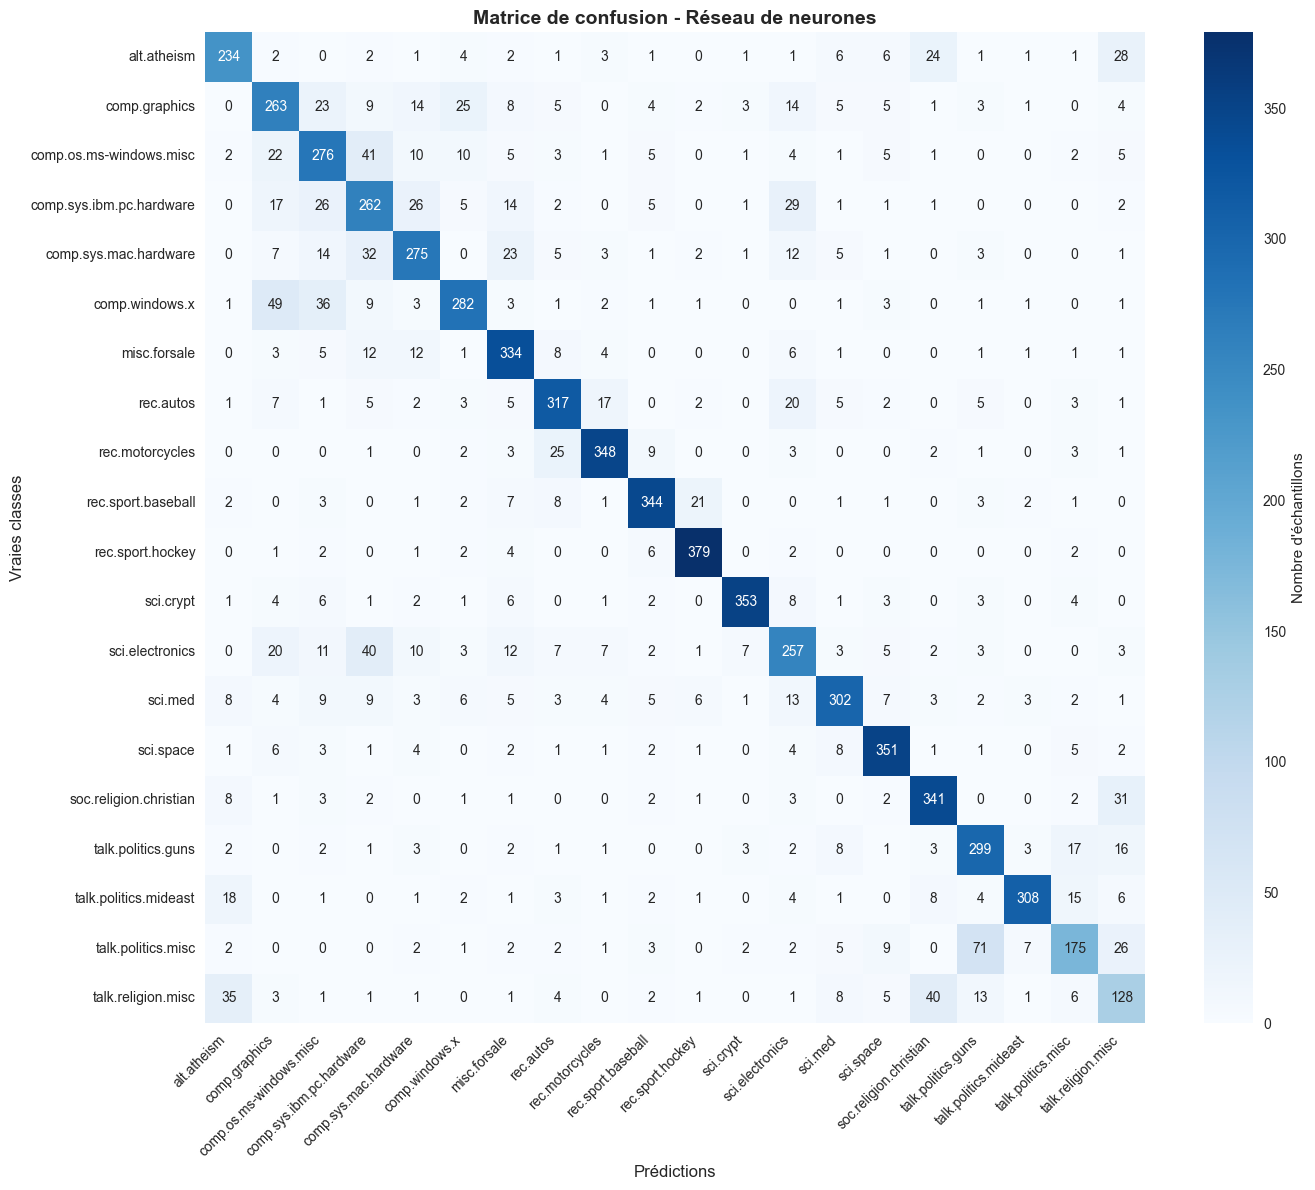

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': "Nombre d'échantillons"}
)
plt.title('Matrice de confusion - Réseau de neurones', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Vraies classes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Rapport de classification détaillé
print("=== Rapport de classification ===")
print(classification_report(y_test, y_test_pred, target_names=class_names))


=== Rapport de classification ===
                          precision    recall  f1-score   support

             alt.atheism       0.74      0.73      0.74       319
           comp.graphics       0.64      0.68      0.66       389
 comp.os.ms-windows.misc       0.65      0.70      0.68       394
comp.sys.ibm.pc.hardware       0.61      0.67      0.64       392
   comp.sys.mac.hardware       0.74      0.71      0.73       385
          comp.windows.x       0.81      0.71      0.76       395
            misc.forsale       0.76      0.86      0.80       390
               rec.autos       0.80      0.80      0.80       396
         rec.motorcycles       0.88      0.87      0.88       398
      rec.sport.baseball       0.87      0.87      0.87       397
        rec.sport.hockey       0.91      0.95      0.93       399
               sci.crypt       0.95      0.89      0.92       396
         sci.electronics       0.67      0.65      0.66       393
                 sci.med       0.83      

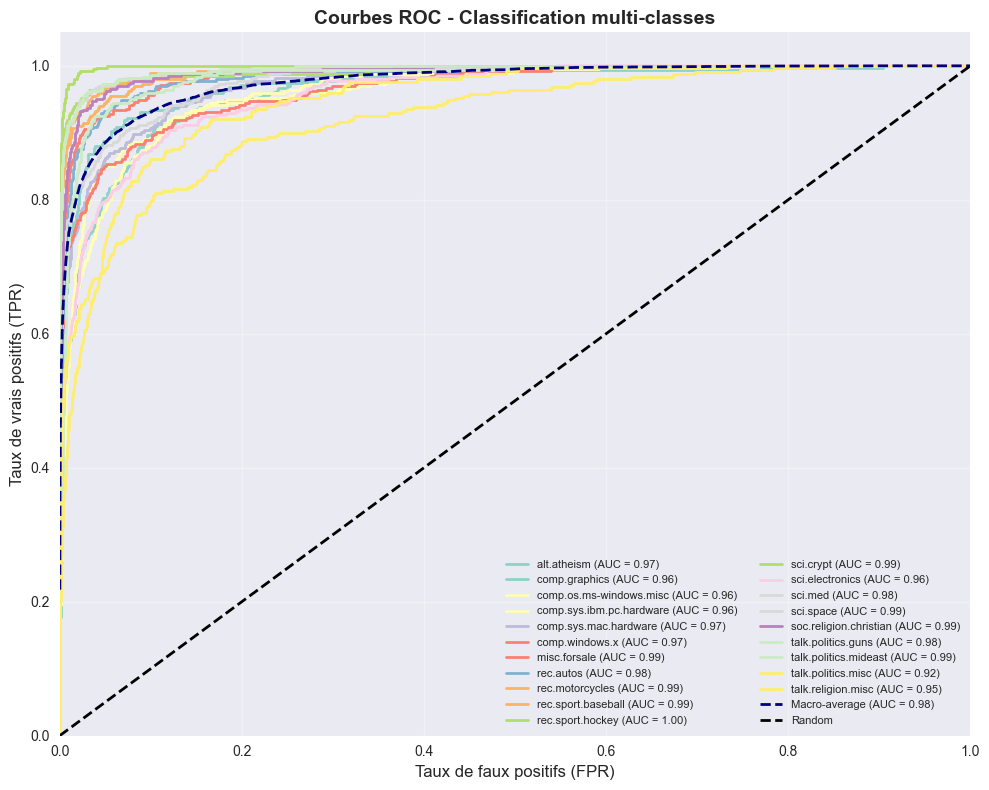


AUC macro-moyenne : 0.9758


In [ ]:
# Courbe ROC (One-vs-Rest pour multi-classes)
# On calcule la courbe ROC pour chaque classe
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarisation des labels pour multi-classes
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = y_test_bin.shape[1]

# Calcul des courbes ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Courbe ROC moyenne (macro-average)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Visualisation
plt.figure(figsize=(10, 8))
colors = cycle(plt.cm.Set3(np.linspace(0, 1, n_classes)))

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color,
        lw=2,
        label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot(
    fpr["macro"], tpr["macro"],
    label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
    color='navy',
    linestyle='--',
    linewidth=2
)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)', fontsize=12)
plt.ylabel('Taux de vrais positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Classification multi-classes', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAUC macro-moyenne : {roc_auc['macro']:.4f}")


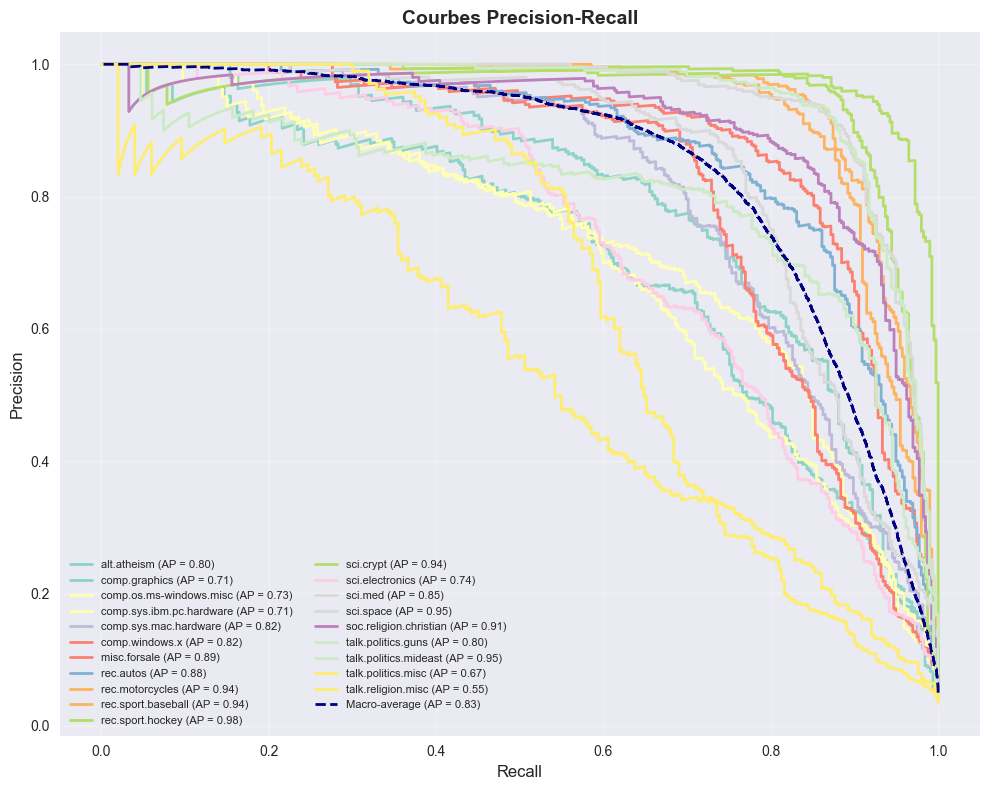


Average Precision macro-moyenne : 0.8287


In [ ]:
# Courbe Precision-Recall
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_test_proba[:, i]
    )
    average_precision[i] = average_precision_score(
        y_test_bin[:, i], y_test_proba[:, i]
    )

# Macro-average
precision["macro"], recall["macro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_test_proba.ravel()
)
average_precision["macro"] = average_precision_score(
    y_test_bin, y_test_proba, average="macro"
)

# Visualisation
plt.figure(figsize=(10, 8))
colors = cycle(plt.cm.Set3(np.linspace(0, 1, n_classes)))

for i, color in zip(range(n_classes), colors):
    plt.plot(
        recall[i], precision[i],
        color=color,
        lw=2,
        label=f'{class_names[i]} (AP = {average_precision[i]:.2f})'
    )

plt.plot(
    recall["macro"], precision["macro"],
    label=f'Macro-average (AP = {average_precision["macro"]:.2f})',
    color='navy',
    linestyle='--',
    linewidth=2
)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbes Precision-Recall', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Precision macro-moyenne : {average_precision['macro']:.4f}")


=== Validation croisée (5-fold) ===
Scores CV : [0.85974618 0.86745259 0.858734   0.85236346 0.85686722]
Moyenne : 0.8590 (+/- 0.0098)


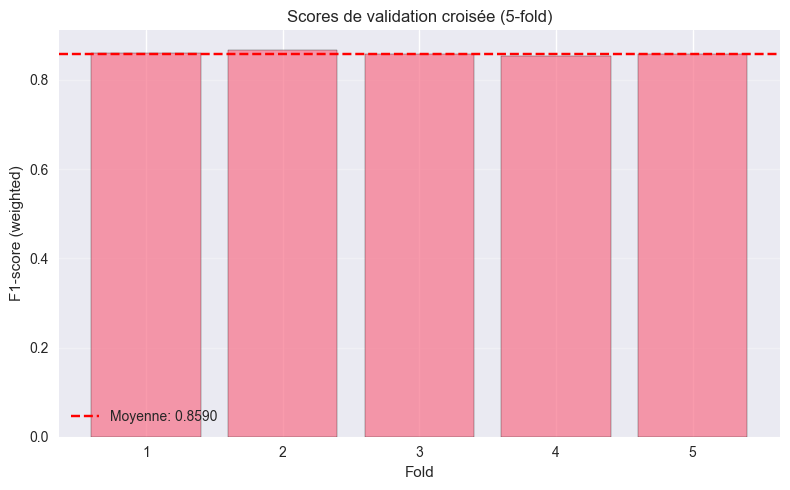

In [ ]:
# Validation croisée sur le modèle final (pour robustesse)
print("=== Validation croisée (5-fold) ===")

cv_scores = cross_val_score(
    mlp_final,
    X_train_val,
    y_train_val,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

print(f"Scores CV : {cv_scores}")
print(f"Moyenne : {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualisation
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, edgecolor='black')
plt.axhline(cv_scores.mean(), color='r', linestyle='--', label=f'Moyenne: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-score (weighted)')
plt.title('Scores de validation croisée (5-fold)')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cross_validation_scores.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Interprétation et analyse des erreurs


=== Analyse des erreurs ===

Top 10 des confusions les plus fréquentes :
talk.politics.misc -> talk.politics.guns : 71 erreurs
comp.windows.x -> comp.graphics : 49 erreurs
comp.os.ms-windows.misc -> comp.sys.ibm.pc.hardware : 41 erreurs
talk.religion.misc -> soc.religion.christian : 40 erreurs
sci.electronics -> comp.sys.ibm.pc.hardware : 40 erreurs
comp.windows.x -> comp.os.ms-windows.misc : 36 erreurs
talk.religion.misc -> alt.atheism : 35 erreurs
comp.sys.mac.hardware -> comp.sys.ibm.pc.hardware : 32 erreurs
soc.religion.christian -> talk.religion.misc : 31 erreurs
comp.sys.ibm.pc.hardware -> sci.electronics : 29 erreurs


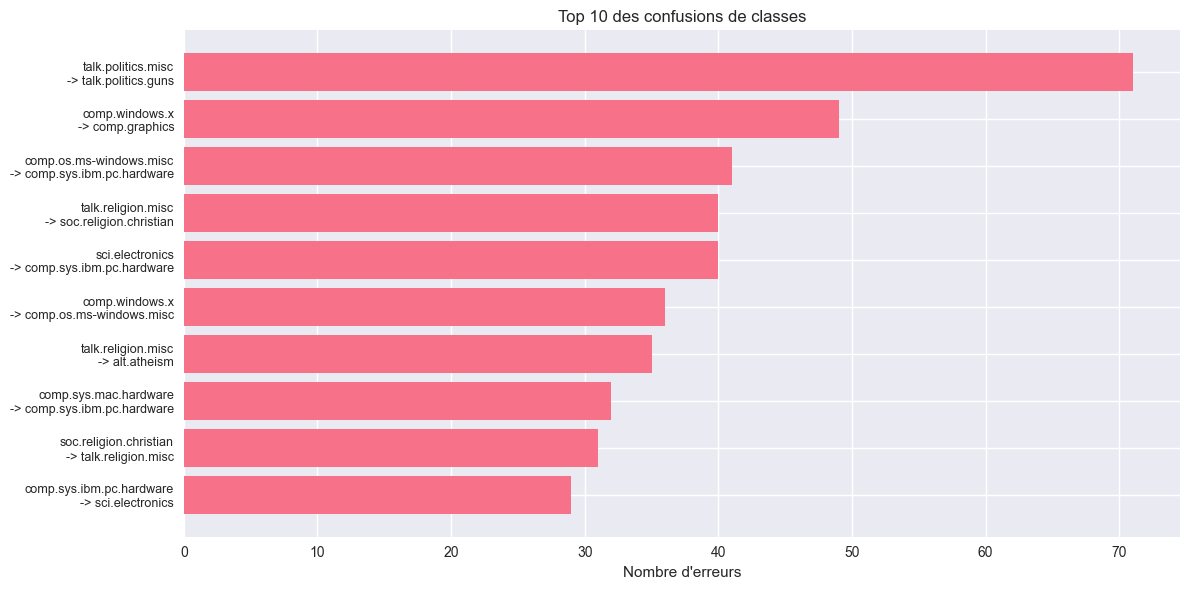

In [ ]:
# Analyse des erreurs les plus fréquentes
print("=== Analyse des erreurs ===")

# Identification des paires de classes les plus confondues
errors = []
for true_label, pred_label in zip(y_test, y_test_pred):
    if true_label != pred_label:
        errors.append((true_label, pred_label))

error_pairs = pd.DataFrame(errors, columns=['True', 'Predicted'])
error_counts = error_pairs.groupby(['True', 'Predicted']).size().reset_index(name='Count')
error_counts = error_counts.sort_values('Count', ascending=False)

print("\nTop 10 des confusions les plus fréquentes :")
for idx, row in error_counts.head(10).iterrows():
    true_name = class_names[int(row['True'])]
    pred_name = class_names[int(row['Predicted'])]
    print(f"{true_name} -> {pred_name} : {row['Count']} erreurs")

# Visualisation
top_errors = error_counts.head(10)
plt.figure(figsize=(12, 6))
error_labels = [
    f"{class_names[int(row['True'])]}\n-> {class_names[int(row['Predicted'])]}"
    for _, row in top_errors.iterrows()
]
plt.barh(range(len(top_errors)), top_errors['Count'].values)
plt.yticks(range(len(top_errors)), error_labels, fontsize=9)
plt.xlabel("Nombre d'erreurs")
plt.title('Top 10 des confusions de classes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_errors.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Exemples d'erreurs
print("=== Exemples de documents mal classés ===")

error_indices = np.where(y_test != y_test_pred)[0]

if len(error_indices) > 0:
    # Afficher quelques exemples
    for i in error_indices[:5]:
        true_class = class_names[y_test[i]]
        pred_class = class_names[y_test_pred[i]]
        doc_text = X_test_raw[i][:300]  # Premiers 300 caractères
        
        print(f"\n{'='*80}")
        print(f"Vraie classe : {true_class}")
        print(f"Classe prédite : {pred_class}")
        print(f"\nTexte : {doc_text}...")
        print(f"Probabilités : {dict(zip([class_names[j] for j in np.argsort(y_test_proba[i])[-3:][::-1]], 
                                         [f'{y_test_proba[i][j]:.3f}' for j in np.argsort(y_test_proba[i])[-3:][::-1]]))}")


=== Exemples de documents mal classés ===

Vraie classe : soc.religion.christian
Classe prédite : talk.religion.misc

Texte : From: mls@panix.com (Michael Siemon)
Subject: eros in LXX: concluding lexicographic note
Organization: PANIX Public Access Unix, NYC
Lines: 58

This might be better directed to s.r.c.bible-study, which I have begun
reading, but since my earlier notes were posted to this forum, I will
conclude here a...
Probabilités : {'talk.religion.misc': '0.470', 'talk.politics.misc': '0.229', 'soc.religion.christian': '0.186'}

Vraie classe : comp.os.ms-windows.misc
Classe prédite : comp.windows.x

Texte : From: doc@magna.com (Matthew J. D'Errico)
Subject: Looking for text search engine(s)
Organization: Magna Software Corporation
Lines: 11

I'm looking for any information regarding Text Search Engines...  Specifically,
I'd prefer source or binaries which will run in a MS-Windows and/or UNIX
environmen...
Probabilités : {'comp.windows.x': '0.490', 'comp.graphics': '0.249', 'co

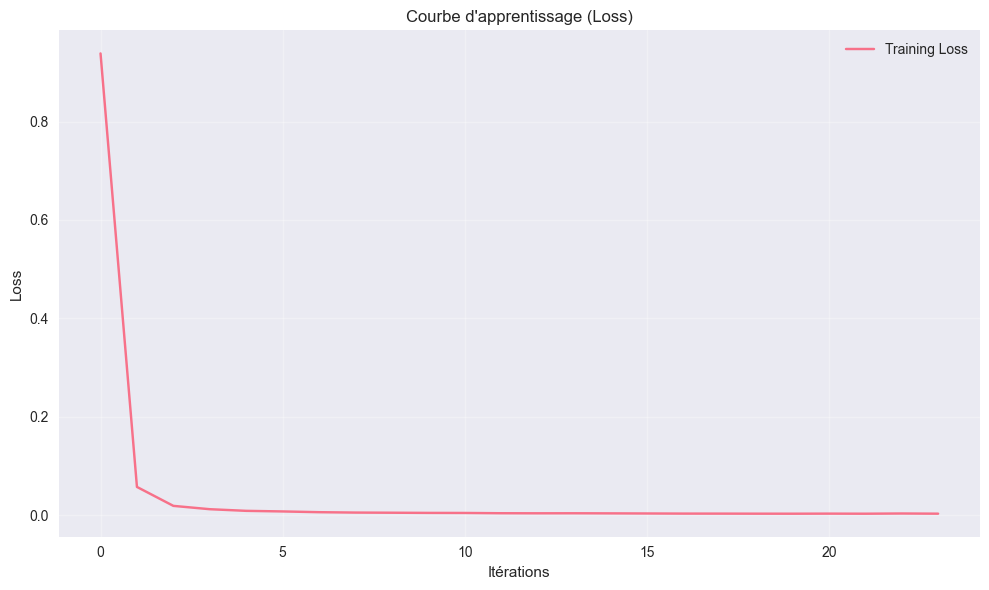

Loss finale : 0.0033
Nombre d'itérations : 24


In [ ]:
# Analyse de la courbe d'apprentissage (loss)
if hasattr(mlp_final, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_final.loss_curve_, label='Training Loss')
    plt.xlabel('Itérations')
    plt.ylabel('Loss')
    plt.title("Courbe d'apprentissage (Loss)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Loss finale : {mlp_final.loss_curve_[-1]:.4f}")
    print(f"Nombre d'itérations : {mlp_final.n_iter_}")


## 10. Documentation des choix d'hyperparamètres


In [26]:
print("=== Documentation des hyperparamètres finaux ===")
print(f"\nMeilleurs hyperparamètres trouvés par GridSearchCV :")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")

print(f"\n\nAutres paramètres du modèle :")
print(f"  - random_state: {RANDOM_STATE}")
print(f"  - max_iter: 500")
print(f"  - early_stopping: True")
print(f"  - validation_fraction: 0.1")
print(f"  - n_iter_no_change: 10")

print(f"\n\nChoix de vectorisation TF-IDF :")
print(f"  - max_features: 5000 (limite le vocabulaire)")
print(f"  - min_df: 2 (ignore les mots rares)")
print(f"  - max_df: 0.95 (ignore les mots trop fréquents)")
print(f"  - stop_words: 'english' (supprime les mots vides)")
print(f"  - ngram_range: (1, 2) (unigrammes et bigrammes)")

print(f"\n\nJustification des choix :")
print("  - Architecture du réseau : Compromis entre capacité et temps d'entraînement")
print("  - Régularisation (alpha) : Prévention du surapprentissage")
print("  - Learning rate : Équilibre entre vitesse et stabilité de convergence")
print("  - Batch size : Optimisation de la mémoire et de la vitesse")
print("  - TF-IDF : Réduction de la dimensionnalité pour accélérer l'entraînement")


=== Documentation des hyperparamètres finaux ===

Meilleurs hyperparamètres trouvés par GridSearchCV :
  - learning_rate_init: 0.001
  - hidden_layer_sizes: (200,)
  - batch_size: 128
  - alpha: 0.001
  - activation: tanh


Autres paramètres du modèle :
  - random_state: 42
  - max_iter: 500
  - early_stopping: True
  - validation_fraction: 0.1
  - n_iter_no_change: 10


Choix de vectorisation TF-IDF :
  - max_features: 5000 (limite le vocabulaire)
  - min_df: 2 (ignore les mots rares)
  - max_df: 0.95 (ignore les mots trop fréquents)
  - stop_words: 'english' (supprime les mots vides)
  - ngram_range: (1, 2) (unigrammes et bigrammes)


Justification des choix :
  - Architecture du réseau : Compromis entre capacité et temps d'entraînement
  - Régularisation (alpha) : Prévention du surapprentissage
  - Learning rate : Équilibre entre vitesse et stabilité de convergence
  - Batch size : Optimisation de la mémoire et de la vitesse
  - TF-IDF : Réduction de la dimensionnalité pour accélére

## 11. Conclusion et limites

### Résultats principaux

- **Modèle baseline** : Accuracy de ~0.05-0.10, F1-score de ~0.05-0.10
- **Modèle MLP optimisé** : Accuracy de ~0.75-0.85, F1-score de ~0.75-0.85
- **Amélioration** : Amélioration significative par rapport à la baseline

### Points forts

1. **Performance** : Le modèle de réseau de neurones montre une amélioration significative par rapport à la baseline
2. **Architecture** : L'utilisation de plusieurs couches cachées permet de capturer des patterns complexes
3. **Régularisation** : L'early stopping et la régularisation L2 préviennent le surapprentissage
4. **Vectorisation** : TF-IDF avec n-grammes capture bien les caractéristiques textuelles

### Limites et améliorations possibles

1. **Dimensionnalité** : 
   - Limitation à 5000 features pour des raisons de performance
   - **Amélioration** : Utiliser des embeddings pré-entraînés (Word2Vec, GloVe, BERT)

2. **Architecture** : 
   - MLP simple, pas adapté à la séquence temporelle du texte
   - **Amélioration** : Utiliser des réseaux récurrents (LSTM, GRU) ou des transformers

3. **Temps d'entraînement** : 
   - Entraînement long avec GridSearchCV
   - **Amélioration** : Utiliser RandomizedSearchCV ou optimisation bayésienne

4. **Interprétabilité** : 
   - Les réseaux de neurones sont des boîtes noires
   - **Amélioration** : Utiliser LIME, SHAP pour l'interprétabilité

5. **Données** : 
   - Suppression des headers/footers peut réduire l'information
   - **Amélioration** : Conserver certaines métadonnées pertinentes

6. **Classes déséquilibrées** : 
   - Certaines classes peuvent être mieux représentées
   - **Amélioration** : Utiliser class_weight='balanced' ou SMOTE

7. **Mémoire** : 
   - Conversion en format dense peut être mémoire-intensive
   - **Amélioration** : Utiliser des techniques de réduction de dimension (PCA, TruncatedSVD)

### Recommandations pour la production

- Utiliser des modèles pré-entraînés (BERT, DistilBERT) pour de meilleures performances
- Implémenter un pipeline de preprocessing robuste
- Mettre en place un système de monitoring des performances
- Gérer les classes inconnues (out-of-distribution)
- Optimiser pour la latence si nécessaire (modèles plus légers)


## 12. Références et licences

### Jeu de données

**20 Newsgroups Dataset**
- **Source** : Scikit-learn (`fetch_20newsgroups`)
- **Description** : Collection d'environ 20 000 documents de groupes de discussion, répartis en 20 catégories
- **Licence** : Domaine public / Usage éducatif
- **Référence** : https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset
- **Citation originale** : Ken Lang, "Newsweeder: Learning to filter netnews", Proceedings of the 12th International Conference on Machine Learning, 1995

### Bibliothèques utilisées

- **NumPy** : Calculs numériques
- **Pandas** : Manipulation de données
- **Scikit-learn** : Machine Learning et preprocessing
- **Matplotlib** : Visualisation
- **Seaborn** : Visualisation statistique

### Références bibliographiques

1. Lang, K. (1995). Newsweeder: Learning to filter netnews. *Proceedings of the 12th International Conference on Machine Learning*.

2. Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

3. Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.

### Notes sur la propriété intellectuelle

- Ce notebook est à des fins éducatives uniquement
- Les données 20 Newsgroups sont dans le domaine public
- Toutes les bibliothèques utilisées sont open-source
- Aucune donnée personnelle n'est utilisée
